In [1]:
cd '/content/drive/MyDrive/Workspace/학부_수업/4-1학기/컴퓨터비전/실습'

/content/drive/MyDrive/Workspace/학부_수업/4-1학기/컴퓨터비전/실습


In [17]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2 as cv
import sys

def construct_yolo_v3():
    f=open('./coco_names.txt', 'r')
    class_names=[line.strip() for line in f.readlines()]

    model=cv.dnn.readNet('yolov3.weights','yolov3.cfg')
    layer_names=model.getLayerNames()
    out_layers=[layer_names[i-1] for i in model.getUnconnectedOutLayers()]

    return model,out_layers,class_names

def yolo_detect(img,yolo_model,out_layers):
    height,width=img.shape[0],img.shape[1]
    test_img=cv.dnn.blobFromImage(img,1.0/256,(448,448),(0,0,0),swapRB=True)

    yolo_model.setInput(test_img)
    output3=yolo_model.forward(out_layers)

    box,conf,id=[],[],[]		# 박스, 신뢰도, 부류 번호
    for output in output3:
        for vec85 in output:
            scores=vec85[5:]
            class_id=np.argmax(scores)
            confidence=scores[class_id]
            if confidence>0.5:	# 신뢰도가 50% 이상인 경우만 취함
                centerx,centery=int(vec85[0]*width),int(vec85[1]*height)
                w,h=int(vec85[2]*width),int(vec85[3]*height)
                x,y=int(centerx-w/2),int(centery-h/2)
                box.append([x,y,x+w,y+h])
                conf.append(float(confidence))
                id.append(class_id)

    ind=cv.dnn.NMSBoxes(box,conf,0.5,0.4)
    objects=[box[i]+[conf[i]]+[id[i]] for i in range(len(box)) if i in ind]
    return objects

Object detection by YOLO v.3


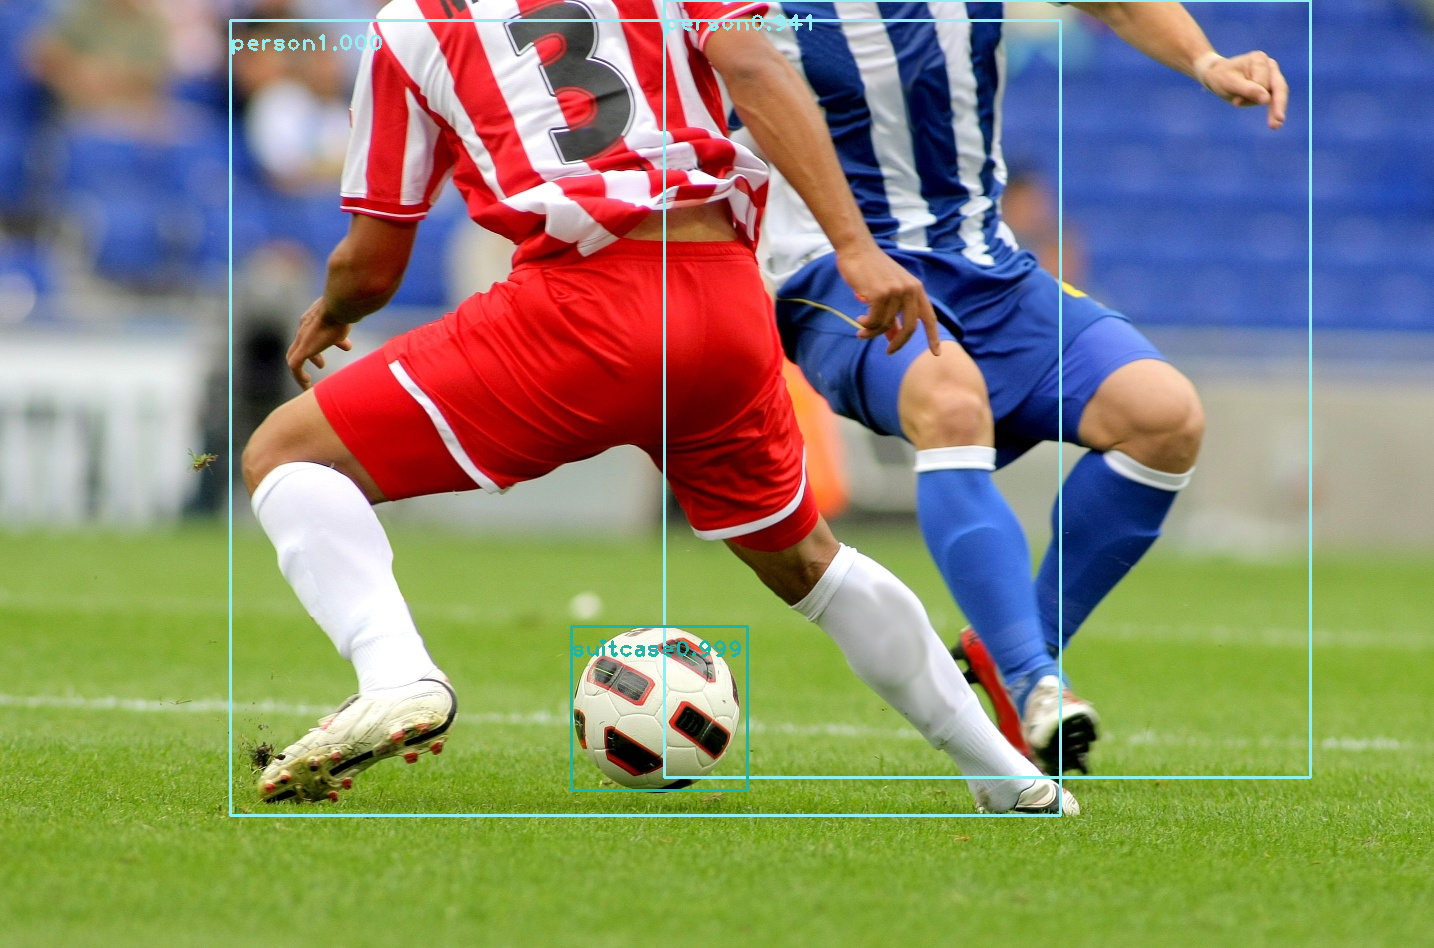

In [18]:
model,out_layers,class_names=construct_yolo_v3()		# YOLO 모델 생성
colors=np.random.uniform(0,255,size=(len(class_names),3))	# 부류마다 색깔

img=cv.imread('soccer.jpg')
if img is None: sys.exit('파일이 없습니다.')

res=yolo_detect(img,model,out_layers)	# YOLO 모델로 물체 검출

for i in range(len(res)):			# 검출된 물체를 영상에 표시
    x1,y1,x2,y2,confidence,id=res[i]
    text=str(class_names[id])+'%.3f'%confidence
    cv.rectangle(img,(x1,y1),(x2,y2),colors[id],2)
    cv.putText(img,text,(x1,y1+30),cv.FONT_HERSHEY_PLAIN,1.5,colors[id],2)

# 객체 인식 결과 정확하게 사람과 공을 분류하는 것을 확인할 수 있음.
print("Object detection by YOLO v.3")
cv2_imshow(img)

cv.waitKey()
cv.destroyAllWindows()

# 실습4

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import os
import random
import cv2 as cv

input_dir='./datasets/oxford_pets/images/images/'
target_dir='./datasets/oxford_pets/annotations/annotations/trimaps/'
img_siz=(160,160)	# 모델에 입력되는 영상 크기
n_class=3		# 분할 레이블 (1:물체, 2:배경, 3:경계)
batch_siz=32		# 미니 배치 크기

img_paths=sorted([os.path.join(input_dir,f) for f in os.listdir(input_dir) if f.endswith('.jpg')])
label_paths=sorted([os.path.join(target_dir,f) for f in os.listdir(target_dir) if f.endswith('.png') and not f.startswith('.')])

class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size,img_size,img_paths,label_paths):
        self.batch_size=batch_size
        self.img_size=img_size
        self.img_paths=img_paths
        self.label_paths=label_paths

    def __len__(self):
        return len(self.label_paths)//self.batch_size

    def __getitem__(self,idx):
        i=idx*self.batch_size
        batch_img_paths=self.img_paths[i:i+self.batch_size]
        batch_label_paths=self.label_paths[i:i+self.batch_size]
        x=np.zeros((self.batch_size,)+self.img_size+(3,),dtype="float32")
        for j,path in enumerate(batch_img_paths):
            img=load_img(path,target_size=self.img_size)
            x[j]=img
        y=np.zeros((self.batch_size,)+self.img_size+(1,),dtype="uint8")
        for j,path in enumerate(batch_label_paths):
            img=load_img(path,target_size=self.img_size,color_mode="grayscale")
            y[j]=np.expand_dims(img,2)
            y[j]-=1		# 부류 번호를 1,2,3에서 0,1,2로 변환
        return x,y

def make_model(img_size,num_classes):
    inputs=keras.Input(shape=img_size+(3,))

    # U-net의 다운 샘플링(축소 경로)
    x=layers.Conv2D(32,3,strides=2,padding='same')(inputs)
    x=layers.BatchNormalization()(x)
    x=layers.Activation('relu')(x)
    previous_block_activation=x		# 지름길 연결을 위해

    for filters in [64,128,256]:
        x=layers.Activation('relu')(x)
        x=layers.SeparableConv2D(filters,3,padding='same')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation('relu')(x)
        x=layers.SeparableConv2D(filters,3,padding='same')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPooling2D(3,strides=2,padding='same')(x)
        residual=layers.Conv2D(filters,1,strides=2,padding='same')(previous_block_activation)
        x=layers.add([x,residual])	# 지름길 연결
        previous_block_activation=x	# 지름길 연결을 위해

    # U-net의 업 샘플링(확대 경로)
    for filters in [256, 128, 64, 32]:
        x=layers.Activation('relu')(x)
        x=layers.Conv2DTranspose(filters,3,padding='same')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation('relu')(x)
        x=layers.Conv2DTranspose(filters,3,padding='same')(x)
        x=layers.BatchNormalization()(x)
        x=layers.UpSampling2D(2)(x)
        residual=layers.UpSampling2D(2)(previous_block_activation)
        residual=layers.Conv2D(filters,1,padding='same')(residual)
        x=layers.add([x,residual])	# 지름길 연결
        previous_block_activation=x	# 지름길 연결을 위해

    outputs=layers.Conv2D(num_classes,3,activation='softmax',padding='same')(x)
    model=keras.Model(inputs, outputs)	# 모델 생성
    return model

model=make_model(img_siz,n_class)		# 모델 생성

random.Random(1).shuffle(img_paths)
random.Random(1).shuffle(label_paths)
test_samples=int(len(img_paths)*0.1)	# 10%를 테스트 집합으로 사용
train_img_paths=img_paths[:-test_samples]
train_label_paths=label_paths[:-test_samples]
test_img_paths=img_paths[-test_samples:]
test_label_paths=label_paths[-test_samples:]

train_gen=OxfordPets(batch_siz,img_siz,train_img_paths,train_label_paths) # 훈련 집합
test_gen=OxfordPets(batch_siz,img_siz,test_img_paths,test_label_paths) # 검증 집합

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
cb=[keras.callbacks.ModelCheckpoint('oxford_seg.h5',save_best_only=True)] # 학습 결과 자동 저장
model.fit(train_gen,epochs=30,validation_data=test_gen,callbacks=cb)

preds=model.predict(test_gen)	# 예측

cv.imshow('Sample image',cv.imread(test_img_paths[0]))# 0번 영상 디스플레이
cv.imshow('Segmentation label',cv.imread(test_label_paths[0])*64)
cv.imshow('Segmentation prediction',preds[0]) # 0번 영상 예측 결과 디스플레이

cv.waitKey()
cv.destroyAllWindows()